# Trader Performance vs Market Sentiment Analysis


## Overview
This notebook analyzes the relationship between trader performance and crypto market sentiment using historical trade data from Hyperliquid and the Fear & Greed Index.

The objective is to understand how trader behavior, profitability, and risk exposure vary across different sentiment regimes.

What I have done in this notebook:
1. Data preparation and validation
2. Sentiment encoding and alignment
3. Feature engineering for profitability, risk, and behavior
4. Exploratory analysis to uncover sentiment-driven patterns

## Step 1: Environment Setup and Project Structure

This step initializes the environment, imports required libraries, and sets up a consistent project structure for data storage and outputs. Display settings are adjusted to facilitate effective data inspection during exploratory analysis.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)

In [3]:
ROOT = Path.cwd()
DATA_DIR = ROOT / "csv_files"
OUTPUT_DIR = ROOT / "outputs"

DATA_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

print("Data dir:", DATA_DIR)
print("Output dir:", OUTPUT_DIR)

Data dir: D:\Scholar\Pro Max\Projects\ds_bhaskar\csv_files
Output dir: D:\Scholar\Pro Max\Projects\ds_bhaskar\outputs


## Step 2: Trade Data Ingestion and Validation

In this step, historical trade data and sentiment data is loaded and inspected to ensure structural integrity. Key columns are standardized, timestamps are nnormalized, and basic sanity checks are performed to confirm that each row represents a completed trade with valid profit and loss information.


In [4]:
trades = pd.read_csv(DATA_DIR / "historical_data.csv")
sentiment = pd.read_csv(DATA_DIR / "fear_greed_index.csv")

print("Trades shape:", trades.shape)
print("Sentiment shape:", sentiment.shape)

Trades shape: (211224, 16)
Sentiment shape: (2644, 4)


In [5]:
trades = trades.rename(columns={
    "Account": "account",
    "Coin": "symbol",
    "Execution Price": "execution_price",
    "Size Tokens": "size_tokens",
    "Size USD": "size_usd",
    "Side": "side",
    "Timestamp IST": "timestamp_ist",
    "Closed PnL": "closed_pnl",
    "Fee": "fee",
    "Timestamp": "timestamp"
})

In [6]:
trades.info()
trades.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   account           211224 non-null  object 
 1   symbol            211224 non-null  object 
 2   execution_price   211224 non-null  float64
 3   size_tokens       211224 non-null  float64
 4   size_usd          211224 non-null  float64
 5   side              211224 non-null  object 
 6   timestamp_ist     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   closed_pnl        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  timestamp         211224 non-null  float64
dtypes: bool(1), float64(

,account,symbol,execution_price,size_tokens,size_usd,side,timestamp_ist,Start Position,Direction,closed_pnl,Transaction Hash,Order ID,Crossed,fee,Trade ID,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12
5,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9900,1.41,11.27,BUY,02-12-2024 22:50,1298.215466,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.000493,7.330000e+14,1.730000e+12
6,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9934,144.09,1151.77,BUY,02-12-2024 22:50,1299.624972,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,9.060000e+14,1.730000e+12
7,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,34.00,272.00,BUY,02-12-2024 22:50,1443.664541,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.011900,3.960000e+14,1.730000e+12
8,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,46.00,368.00,BUY,02-12-2024 22:50,1477.652641,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.016100,9.460000e+14,1.730000e+12
9,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,8.0000,12.50,100.00,BUY,02-12-2024 22:50,1523.636541,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.004375,3.470000e+13,1.730000e+12


In [7]:
trades["timestamp"] = pd.to_datetime(trades["timestamp"], unit="ms", errors="coerce")
trades["trade_date"] = trades["timestamp"].dt.date

In [8]:
trades.info()
trades.head()
trades["closed_pnl"].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   account           211224 non-null  object        
 1   symbol            211224 non-null  object        
 2   execution_price   211224 non-null  float64       
 3   size_tokens       211224 non-null  float64       
 4   size_usd          211224 non-null  float64       
 5   side              211224 non-null  object        
 6   timestamp_ist     211224 non-null  object        
 7   Start Position    211224 non-null  float64       
 8   Direction         211224 non-null  object        
 9   closed_pnl        211224 non-null  float64       
 10  Transaction Hash  211224 non-null  object        
 11  Order ID          211224 non-null  int64         
 12  Crossed           211224 non-null  bool          
 13  fee               211224 non-null  float64       
 14  Trad

count    211224.000000
mean         48.749001
std         919.164828
min     -117990.104100
25%           0.000000
50%           0.000000
75%           5.792797
max      135329.090100
Name: closed_pnl, dtype: float64

## Step 3: Market Sentiment Encoding and Alignment

This step processes the Bitcoin Fear & Greed Index and aligns it with the trade data on a daily basis. Sentiment is encoded in both binary and ordinal forms to capture directional bias and emotional intensity, while ensuring that no excess information is introduced into the analysis.

In [9]:
sentiment = sentiment.rename(columns={
    "classification": "sentiment",
    "value": "sentiment_value"
})

In [10]:
sentiment.info()
sentiment.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        2644 non-null   int64 
 1   sentiment_value  2644 non-null   int64 
 2   sentiment        2644 non-null   object
 3   date             2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


,timestamp,sentiment_value,sentiment,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05
5,1517895000,8,Extreme Fear,2018-02-06
6,1517981400,36,Fear,2018-02-07
7,1518067800,30,Fear,2018-02-08
8,1518154200,44,Fear,2018-02-09
9,1518240600,54,Neutral,2018-02-10


In [11]:
sentiment["date"] = pd.to_datetime(sentiment["date"], errors="coerce")
sentiment["trade_date"] = sentiment["date"].dt.date

In [12]:
sentiment["sentiment"] = (
    sentiment["sentiment"]
    .astype(str)
    .str.strip()
    .str.lower()
)

sentiment["sentiment"] = sentiment["sentiment"].replace({
    "extreme fear": "extreme_fear",
    "extreme greed": "extreme_greed"
})

In [13]:
sentiment["sentiment_binary"] = sentiment["sentiment"].map({
    "fear": 0,
    "extreme_fear": 0,
    "neutral": np.nan,
    "greed": 1,
    "extreme_greed": 1
})

In [14]:
sentiment["sentiment_ordinal"] = sentiment["sentiment"].map({
    "extreme_fear": -2,
    "fear": -1,
    "neutral": 0,
    "greed": 1,
    "extreme_greed": 2
})

In [15]:
sentiment["sentiment"].value_counts(dropna=False)
sentiment["sentiment_binary"].value_counts(dropna=False)
sentiment["sentiment_ordinal"].value_counts(dropna=False)

sentiment_ordinal
-1    781
 1    633
-2    508
 0    396
 2    326
Name: count, dtype: int64

In [16]:
sentiment_merge = (
    sentiment[["trade_date", "sentiment", "sentiment_binary", "sentiment_ordinal"]]
    .drop_duplicates("trade_date")
)

In [17]:
trades_sentiment = trades.merge(
    sentiment_merge,
    on="trade_date",
    how="left"
)

In [18]:
trades_sentiment[["sentiment", "sentiment_binary"]].isna().mean()

sentiment           0.127642
sentiment_binary    0.161449
dtype: float64

In [19]:
trades_sentiment.to_csv(
    DATA_DIR / "trades_with_sentiment.csv",
    index=False
)

## Step 4: Feature Engineering for Profitability, Risk, and Behavior

In this step, additional features are derived from OG datasets to capture trader profitability, capital efficiency, directional behavior, risk exposure, and temporal patterns. These features transform raw trade data into meaningful signals suitable for exploratory analysis.

In [20]:
df = trades_sentiment.copy()

In [21]:
df["pnl"] = df["closed_pnl"]
df["net_pnl"] = df["closed_pnl"] - df["fee"]
df["return_usd"] = df["net_pnl"] / df["size_usd"]

In [22]:
df["side"] = df["side"].str.lower()

df["direction"] = df["side"].map({
    "buy": 1,
    "sell": -1
})

In [23]:
df["abs_size_usd"] = df["size_usd"].abs()
df["fee_ratio"] = df["fee"] / df["abs_size_usd"]

In [24]:
df["sentiment_direction_interaction"] = (
    df["direction"] * df["sentiment_ordinal"]
)

In [25]:
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek  # 0 = Monday

In [26]:
df["is_profitable"] = (df["net_pnl"] > 0).astype(int)

In [27]:
df[[
    "pnl",
    "net_pnl",
    "return_usd",
    "fee_ratio",
    "abs_size_usd"
]].describe()

,pnl,net_pnl,return_usd,fee_ratio,abs_size_usd
count,211224.000000,211224.000000,211181.000000,211181.000000,2.112240e+05
mean,48.749001,47.585034,0.018646,0.000349,5.639451e+03
std,919.164828,918.621638,0.845870,0.009504,3.657514e+04
min,-117990.104100,-118071.556516,-384.406762,-0.000020,0.000000e+00
25%,0.000000,-0.194153,-0.000300,0.000096,1.937900e+02
50%,0.000000,-0.005857,-0.000048,0.000250,5.970450e+02
75%,5.792797,5.535112,0.010109,0.000350,2.058960e+03
max,135329.090100,135299.803088,3.403500,1.432547,3.921431e+06


In [28]:
feature_path = DATA_DIR / "trades_features.csv"
df.to_csv(feature_path, index=False)

print(f"Saved feature dataset to {feature_path}")

Saved feature dataset to D:\Scholar\Pro Max\Projects\ds_bhaskar\csv_files\trades_features.csv


## Step 5: Exploratory Data Analysis

This step explores how trading activity, profitability, and risk characteristics vary across different market sentiment regimes. Visualizations and summary statistics are used to uncover patterns that link trader behavior to market psychology.

In [29]:
df.shape

(211224, 30)

In [30]:
df[[
    "sentiment",
    "sentiment_binary",
    "sentiment_ordinal",
    "net_pnl",
    "return_usd",
    "abs_size_usd",
    "fee_ratio"
]].isna().mean()

sentiment            0.127642
sentiment_binary     0.161449
sentiment_ordinal    0.127642
net_pnl              0.000000
return_usd           0.000204
abs_size_usd         0.000000
fee_ratio            0.000204
dtype: float64

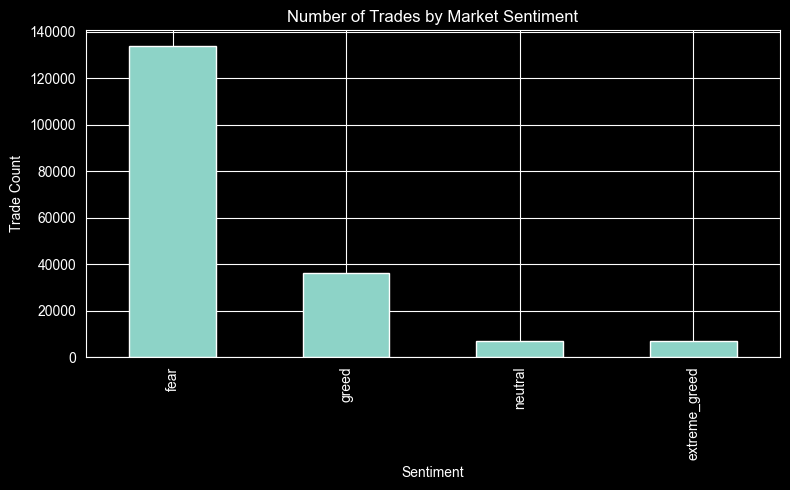

In [31]:
#Do traders trade more during Greed or Fear?

trade_count = (
    df.groupby("sentiment")["account"]
    .count()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))
trade_count.plot(kind="bar")
plt.title("Number of Trades by Market Sentiment")
plt.ylabel("Trade Count")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "trade_count_by_sentiment.png")
plt.show()

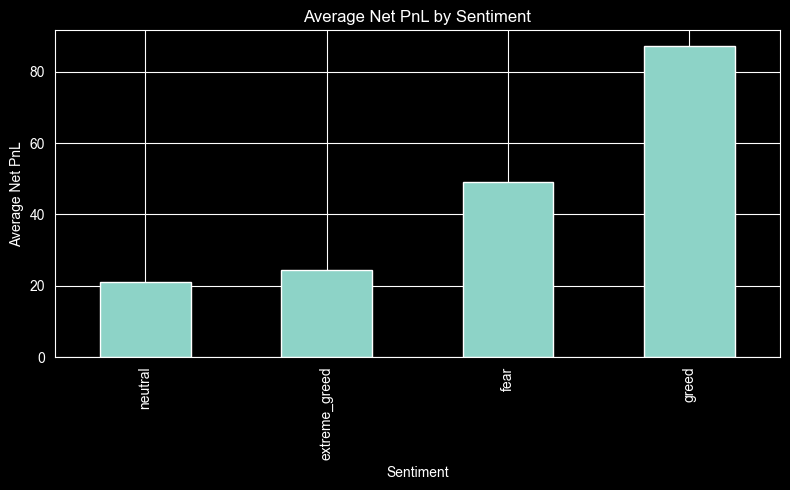

In [32]:
#Are traders more profitable during Fear or Greed?
pnl_by_sentiment = (
    df.groupby("sentiment")["net_pnl"]
    .mean()
    .sort_values()
)

plt.figure(figsize=(8,5))
pnl_by_sentiment.plot(kind="bar")
plt.title("Average Net PnL by Sentiment")
plt.ylabel("Average Net PnL")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "avg_pnl_by_sentiment.png")
plt.show()

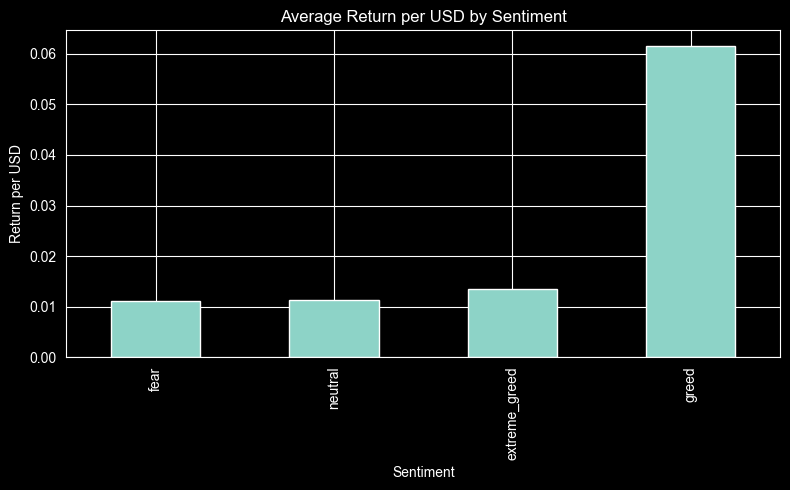

In [33]:
#Do Fear trades have better efficiency per dollar?
ret_by_sentiment = (
    df.groupby("sentiment")["return_usd"]
    .mean()
    .sort_values()
)

plt.figure(figsize=(8,5))
ret_by_sentiment.plot(kind="bar")
plt.title("Average Return per USD by Sentiment")
plt.ylabel("Return per USD")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "return_by_sentiment.png")
plt.show()

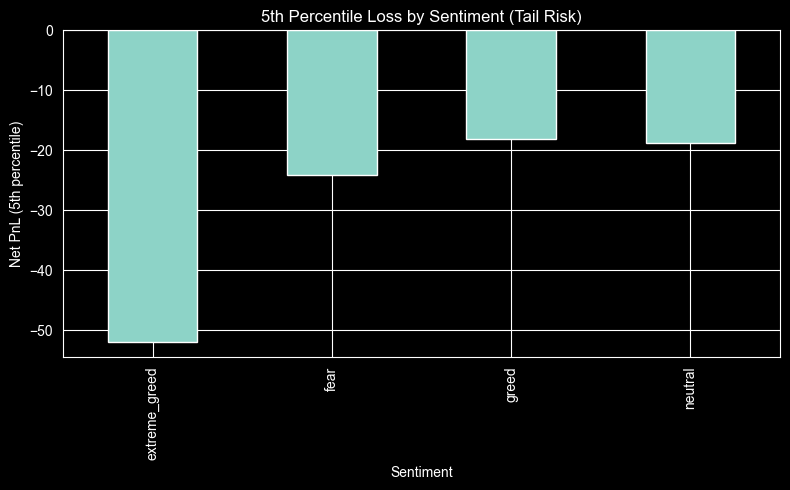

In [34]:
#Are losses worse during Greed?
loss_df = df[df["net_pnl"] < 0]

loss_tail = (
    loss_df.groupby("sentiment")["net_pnl"]
    .quantile(0.05)
)

plt.figure(figsize=(8,5))
loss_tail.plot(kind="bar")
plt.title("5th Percentile Loss by Sentiment (Tail Risk)")
plt.ylabel("Net PnL (5th percentile)")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "tail_loss_by_sentiment.png")
plt.show()

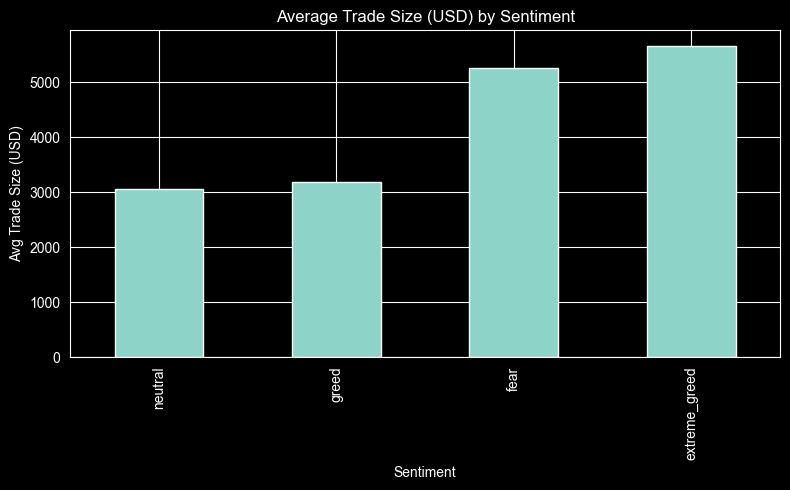

In [35]:
#Do traders take larger positions during Greed?
exposure_by_sentiment = (
    df.groupby("sentiment")["abs_size_usd"]
    .mean()
    .sort_values()
)

plt.figure(figsize=(8,5))
exposure_by_sentiment.plot(kind="bar")
plt.title("Average Trade Size (USD) by Sentiment")
plt.ylabel("Avg Trade Size (USD)")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "exposure_by_sentiment.png")
plt.show()

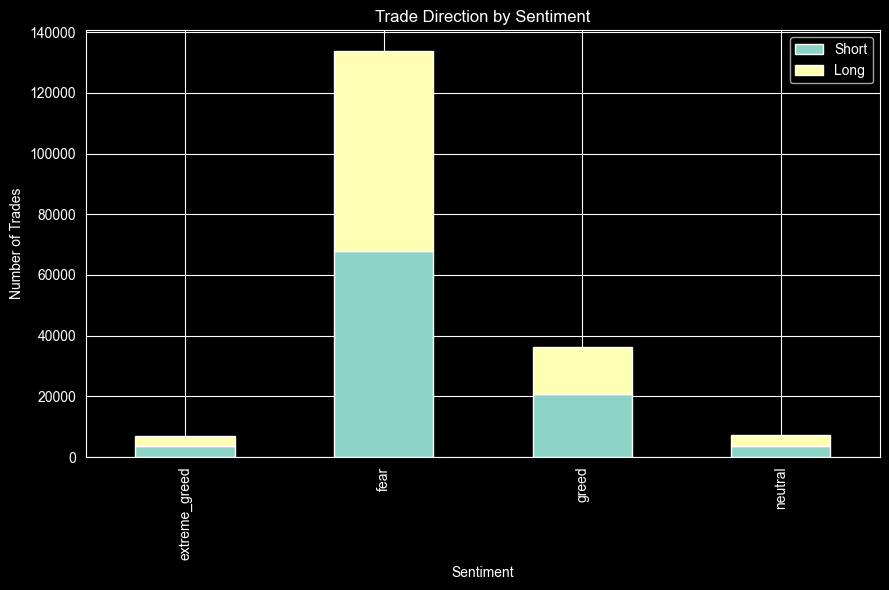

In [36]:
#Do traders chase trends or trade contrarian?
direction_sentiment = (
    df.groupby(["sentiment", "direction"])
    .size()
    .unstack()
)

direction_sentiment.plot(
    kind="bar",
    stacked=True,
    figsize=(9,6)
)

plt.title("Trade Direction by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Trades")
plt.legend(["Short", "Long"])
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "direction_bias_by_sentiment.png")
plt.show()

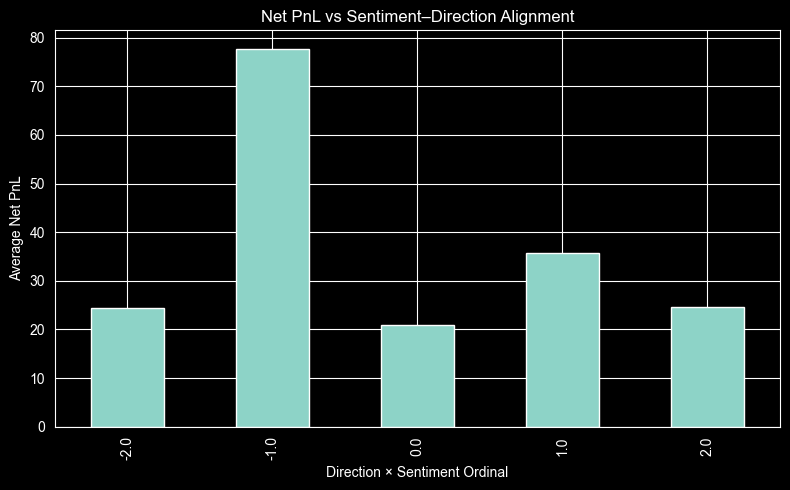

In [37]:
#Does aligning with sentiment improve performance?
interaction_perf = (
    df.groupby("sentiment_direction_interaction")["net_pnl"]
    .mean()
    .sort_index()
)

plt.figure(figsize=(8,5))
interaction_perf.plot(kind="bar")
plt.title("Net PnL vs Sentiment–Direction Alignment")
plt.xlabel("Direction × Sentiment Ordinal")
plt.ylabel("Average Net PnL")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "interaction_pnl.png")
plt.show()

## Summary and Whats Next


This notebook established a clean data pipeline, engineered relevant features, and conducted exploratory analysis to identify sentiment-driven trading patterns. The insights and artifacts produced here serve as the foundation for advanced behavioral analysis and strategy validation conducted in Notebook 2.